# Bayesian Inference Workshop -1: Gene Markers and Disease Prediction

This workshop demonstrates how Bayesian inference can be used to learn the relationship between gene markers and disease probability. We'll see how our beliefs (represented by probability distributions) update as we gather more data.

## Setup
First, let's import our required libraries and set up our environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.special import beta as beta_function

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn')
sns.set_context('notebook')

/var/folders/xz/n_x5kg_d7td4g5fp2sbq_gnr0000gn/T/ipykernel_24440/3399493114.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Define True Distribution

In realistic scenarios, the true probability distribution is unknown. However, for generating synthetic data, we must establish a hypothetical 'true' distribution. In genetics and disease modeling, the probability of a disease given a specific gene marker often varies among individuals rather than being fixed. This variation arises from several factors, including genetic background, environmental influences, and interactions among multiple genes. We model the relationship between our gene marker and the disease probability using a normal distribution, truncated to ensure all probabilities are between 0 and 1. While this approach may not perfectly capture every nuance of biological complexity, it provides a robust approximation that helps estimate the variability and distribution of disease probabilities effectively. This method allows us to simulate data that closely resembles real genetic variability, facilitating more realistic analyses and studies.



In [2]:
# Define true distribution parameters
true_mean = 0.3  # 30% probability of disease given marker
true_std = 0.05  # Standard deviation of probability

def generate_data(n_samples):
    """Generate binary outcomes (disease/no disease) based on true probability"""
    true_probs = np.random.normal(true_mean, true_std, n_samples)
    true_probs = np.clip(true_probs, 0, 1)  # Ensure probabilities are in [0,1]
    return np.random.binomial(1, true_probs)

### Understanding np.random.binomial


The np.random.binomial function in NumPy is used to simulate outcomes from a binomial distribution. This distribution models the number of successes in a given number of trials, each with a specified probability of success.

Usage Example:

```
import numpy as np

# Assume true_probs is an array of probabilities for disease presence
true_probs = np.array([0.3, 0.7, 0.9])
```

### Simulate disease occurrence: 1 trial per probability with varying success rates
```
outcomes = np.random.binomial(1, true_probs)
```
Parameters in Your Code:

1: The number of trials for each experiment (since it's 1, each experiment is just one trial).
true_probs: An array where each element is the probability of success (disease presence) in that single trial.
What Happens:

The function performs one trial for each element in the true_probs array.
It returns an array of outcomes, where each outcome is either 0 (no disease) or 1 (disease present), based on the probability in true_probs.
Output Explanation:

Each element of the output corresponds to an outcome of the trial based on its respective probability. For instance, for a probability of 0.3, there's a 30% chance the output will be 1 (disease present) and a 70% chance it will be 0 (no disease).
This method is useful for simulating scenarios with different probabilities of an event, allowing for realistic modeling of variable outcomes in a population.

## Prior Distribution

Now that we have evidence, we need to select a prior distribution for the parameter mean that we are attempting to estimate. Currently, we lack specific information about the distribution of this prior. We can begin with the simplest approach: a uniform distribution. This choice represents complete uncertainty about the relationship between our gene marker and disease probability. However, do not worry; we will demonstrate how, with the accumulation of data, the estimated mean will increasingly converge to the true mean. This reflects a state of complete prior ignorance, where all probabilities from 0 to 1 are considered equally likely, providing a neutral starting point for Bayesian updating based on the data.

* Note: When both parameters of the Beta distribution are set to 1, the result is a uniform distribution ([Beta distribution on Wikipedia](https://en.wikipedia.org/wiki/Beta_distribution)).

### Beta Distribution as a Prior in Bayesian Statistics

The Beta distribution is commonly used as a prior distribution in Bayesian statistics, particularly when modeling probabilities or proportions. Here are the reasons why it is so favored:

#### 1. Bounded Support [0, 1]
The Beta distribution is defined on the interval [0, 1], which is the natural range for probabilities. This makes it perfectly suited for representing the distribution of a probability value, like the probability of success in a binomial trial.

#### 2. Flexibility in Shape
The shape of the Beta distribution can vary widely depending on its parameters ($\alpha$ and $\beta$):

- **Uniform Distribution**: When $\alpha = 1$ and $\beta = 1$, the Beta distribution becomes a uniform distribution, reflecting complete ignorance about the probability of an event.
- **Skewed Left or Right**: It skews towards 1 when $\alpha > \beta$ (suggesting a higher expected probability of success), and towards 0 when $\beta > \alpha$ (suggesting a lower expected probability).
- **Bell-shaped**: With $\alpha$ and $\beta$ greater than 1 and similar in magnitude, it takes a bell-shaped form, centered around $\frac{\alpha}{\alpha + \beta}$.

#### 3. Conjugacy with Binomial Likelihood
The Beta distribution is a conjugate prior for the binomial likelihood, which means:
- The posterior distribution, after observing outcomes of binomial trials, will also be a Beta distribution.
- This conjugacy allows for straightforward updating of the distribution:
  - **Posterior's $\alpha$**: Prior's $\alpha$ + Number of Successes
  - **Posterior's $\beta$**: Prior's $\beta$ + Number of Failures

#### 4. Analytical Convenience
Due to its conjugacy properties, updates to the Beta distribution in light of new data can often be done analytically, avoiding the need for numerical approximation methods like Monte Carlo simulations.

#### 5. Interpretability
The parameters of the Beta distribution can be interpreted as "pseudo-observations":
- For example, $\alpha = 10$ and $\beta = 5$ might represent having seen 10 successes and 5 failures before any real data collection.

#### Usage Examples
- **Medical Trials**: Used to model the probability of a patient responding to treatment.
- **Quality Control**: Applied in industrial statistics to model defect rates in manufacturing processes.
- **Machine Learning**: Employed in Bayesian models for binary outcomes and in online learning algorithms for dynamically updating success probabilities.

The Beta distribution is a key tool in Bayesian analysis, especially useful when dealing with probabilities and proportions.


In [3]:
# Define prior parameters (Beta distribution) prior_a and prior_b are the initial parameters of the Beta distribution, known as alpha (α) and beta (β), respectively. When both are set to 1, the Beta distribution is equivalent to a uniform distribution over the interval [0, 1], representing complete uncertainty or lack of knowledge about the probability being modeled.
prior_a = 1  # Alpha parameter for Beta distribution
prior_b = 1  # Beta parameter for Beta distribution

def update_beta_parameters(a, b, data):
    """Update Beta distribution parameters with new data"""
    return a + np.sum(data), b + len(data) - np.sum(data)

## Visualization Functions

Let's create functions to visualize how our distributions evolve with more data.

In [4]:
def plot_distributions(data_points, prior_a, prior_b, true_mean, true_std, ax=None):
    """Plot prior, likelihood, and posterior distributions"""

    x = np.linspace(0, 1, 1000)
    
    plt.figure(figsize=(12, 6))
    
    # Plot prior
    prior = stats.beta(prior_a, prior_b)
    plt.plot(x, prior.pdf(x), 'b-', label='Prior (Uniform)', alpha=0.5)

    
    # Plot posterior if we have data
    if len(data_points) > 0:
        post_a, post_b = update_beta_parameters(prior_a, prior_b, data_points)
        posterior = stats.beta(post_a, post_b)
        plt.plot(x, posterior.pdf(x), 'r-', 
                label=f'Posterior (n={len(data_points)})', 
                alpha=0.7)
    
    # add a line as the true mean
    plt.axvline(true_mean, color='g', linestyle='--', label='True Mean Parameter')
    
    plt.title(f'Distribution Comparison (n={len(data_points)})')
    plt.xlabel('Probability of Disease Given Gene Marker')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print statistics if we have data
    if len(data_points) > 0:
        post_a, post_b = update_beta_parameters(prior_a, prior_b, data_points)
        print(f"Posterior mean: {post_a/(post_a + post_b):.3f}")


## Generate Data and Visualize Results

Now let's generate synthetic data and see how our posterior distribution evolves with different sample sizes.

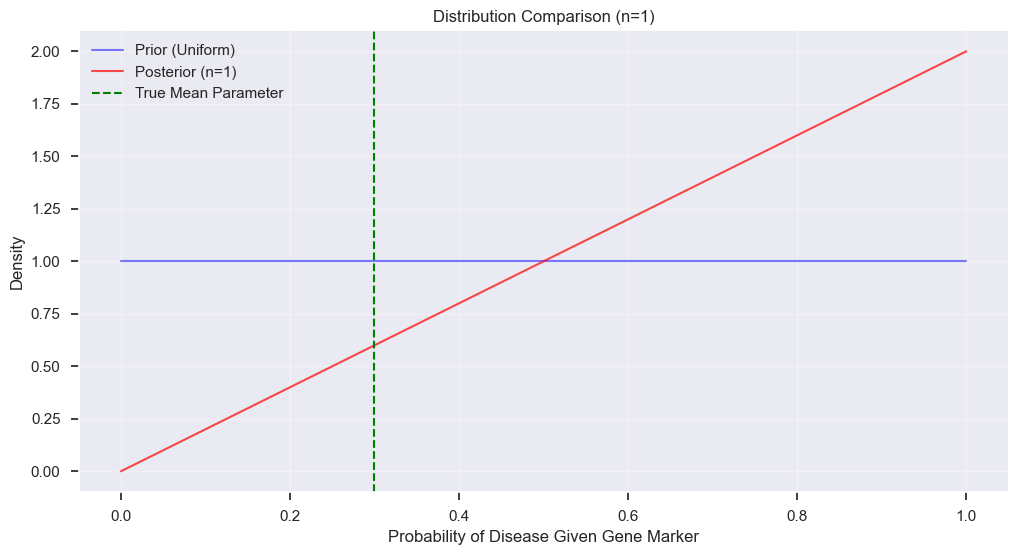

Posterior mean: 0.667


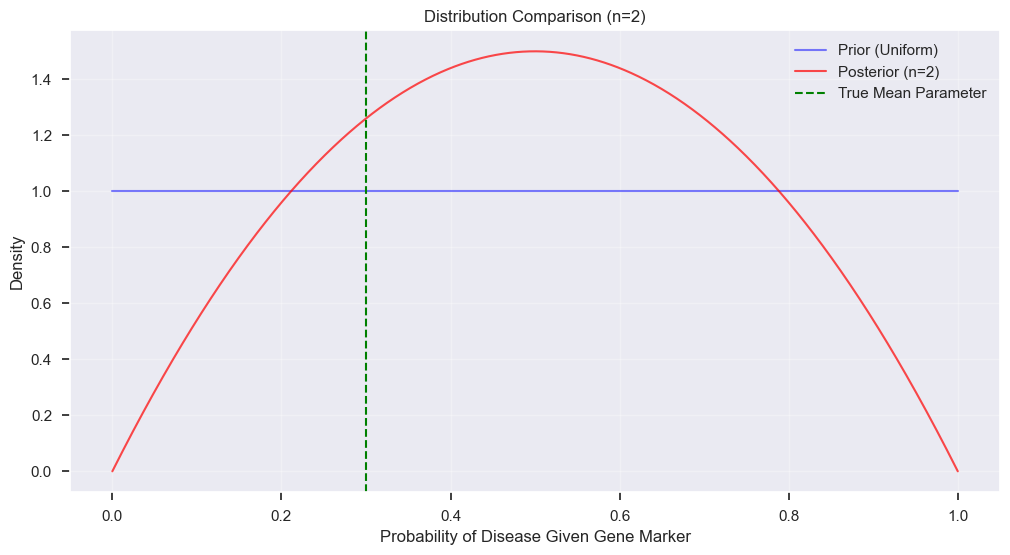

Posterior mean: 0.500


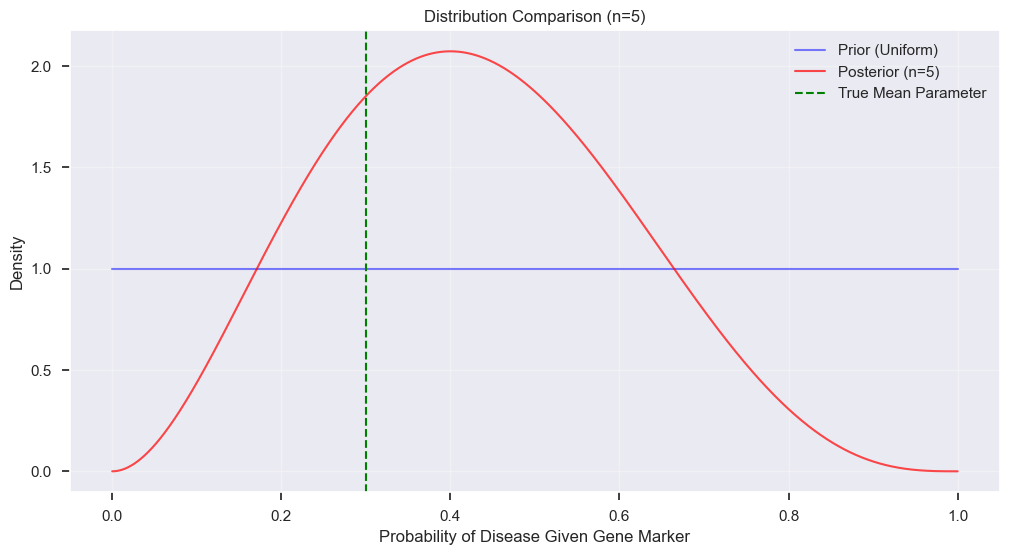

Posterior mean: 0.429


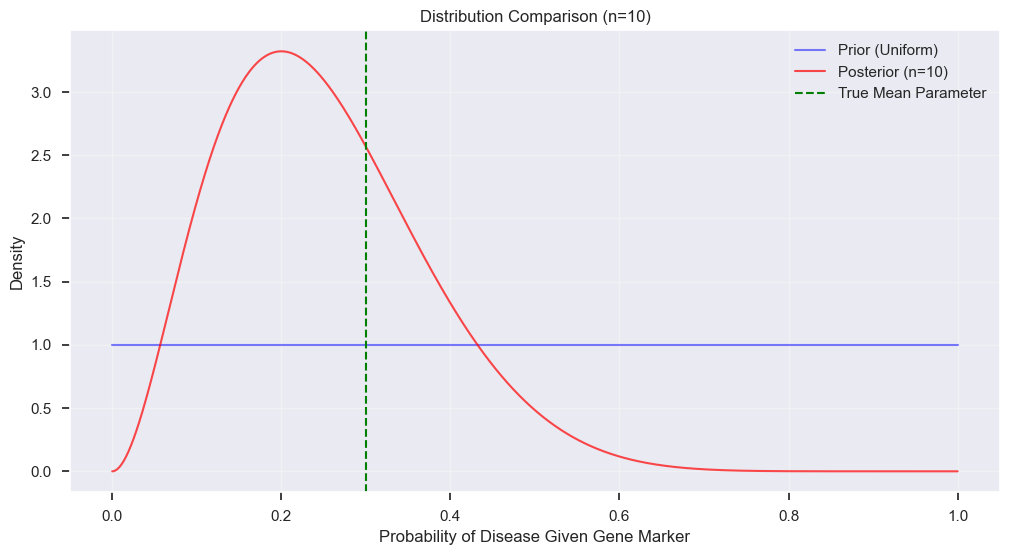

Posterior mean: 0.250


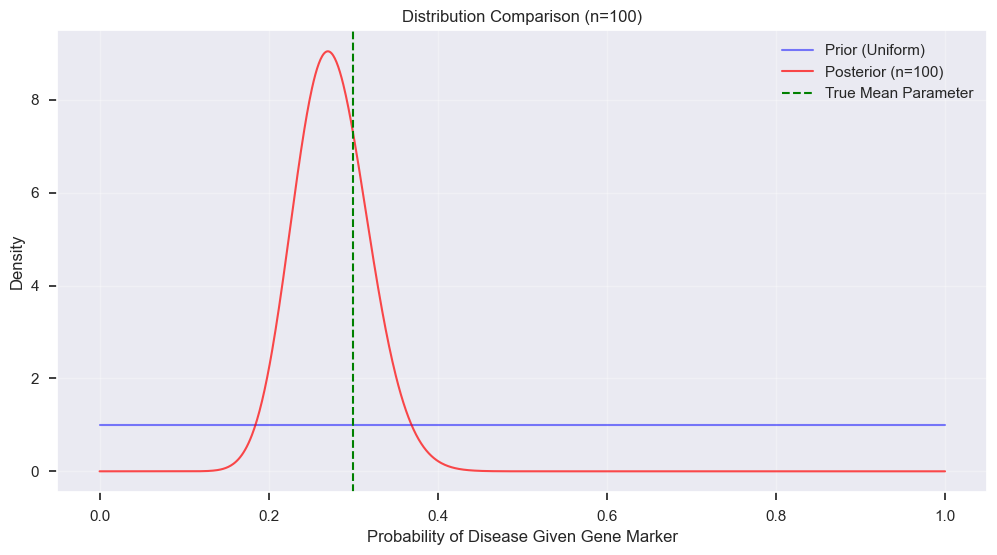

Posterior mean: 0.275


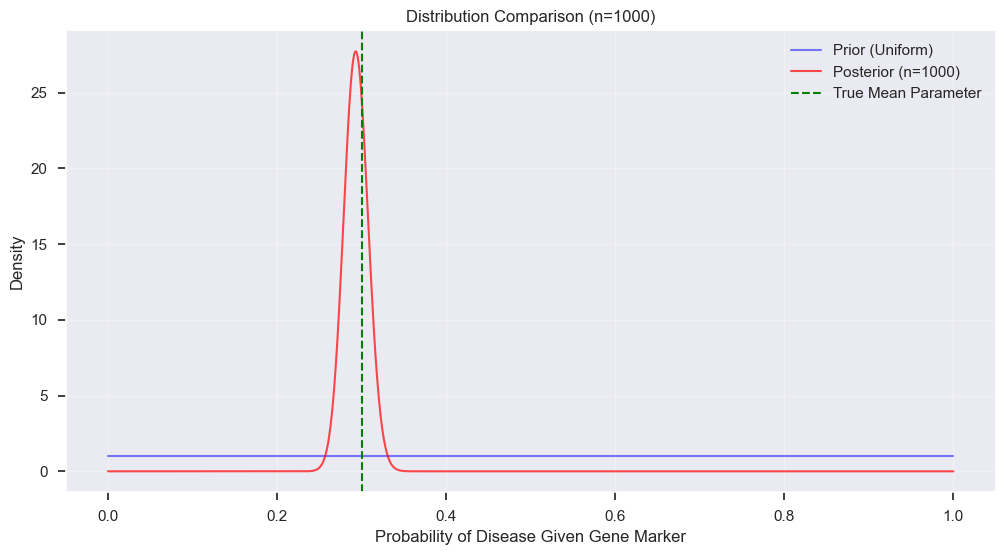

Posterior mean: 0.293


In [7]:
# Generate all data at once
all_data = generate_data(1000)

import matplotlib.pyplot as plt

for i, n in enumerate([1, 2, 5, 10, 100, 1000]):
    plot_distributions(all_data[:n], prior_a, prior_b, true_mean, true_std)



## Convergence Analysis

Let's visualize how our estimates converge to the true probability over time.

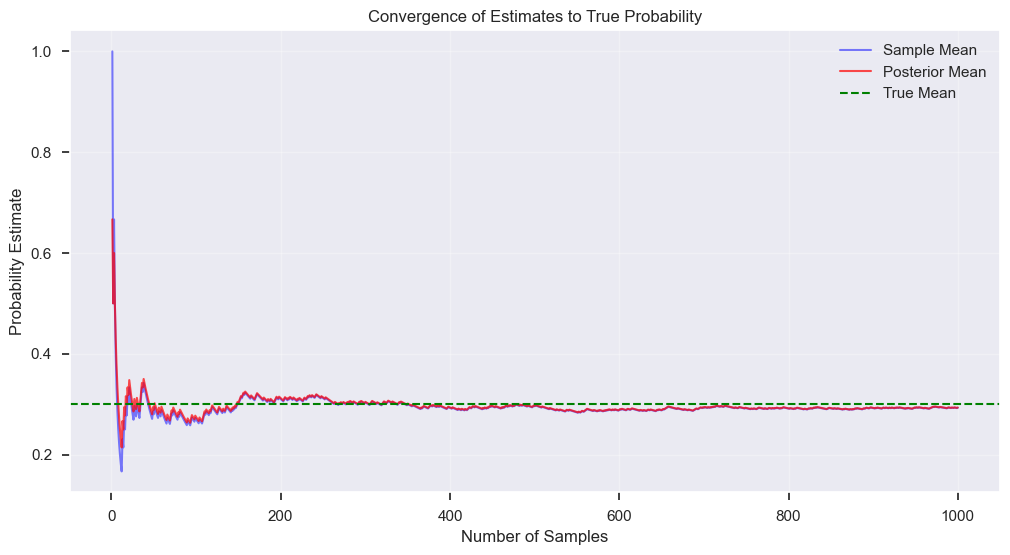

In [8]:
def plot_convergence(data, true_mean):
    """Plot convergence of estimates to true probability"""
    running_means = []
    posterior_means = []
    ns = range(1, len(data) + 1)
    
    current_a = prior_a
    current_b = prior_b
    
    for i in range(len(data)):
        running_means.append(np.mean(data[:i+1]))
        current_a, current_b = update_beta_parameters(prior_a, prior_b, data[:i+1])
        posterior_means.append(current_a / (current_a + current_b))
    
    plt.figure(figsize=(12, 6))
    plt.plot(ns, running_means, 'b-', label='Sample Mean', alpha=0.5)
    plt.plot(ns, posterior_means, 'r-', label='Posterior Mean', alpha=0.7)
    plt.axhline(y=true_mean, color='g', linestyle='--', label='True Mean')
    plt.xlabel('Number of Samples')
    plt.ylabel('Probability Estimate')
    plt.title('Convergence of Estimates to True Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot convergence
plot_convergence(all_data, true_mean)

## Conclusions

Key observations from this workshop:

1. **Prior Distribution**:
   - We started with a uniform prior (Beta(1,1)), representing complete uncertainty
   - This is an uninformative prior that gives equal probability to all possible values

2. **True Distribution**:
   - The true distribution is normal with mean=0.3 and std=0.05
   - This represents the actual probability of disease given the gene marker

3. **Posterior Evolution**:
   - With 10 samples: Initial shape begins to form but still quite uncertain
   - With 100 samples: Much closer to true distribution, narrower confidence interval
   - With 1000 samples: Very close to true distribution, tight confidence interval

4. **Convergence**:
   - The posterior mean converges to the true mean as we get more data
   - The variance of the posterior distribution decreases with more data
   - This demonstrates how Bayesian updating allows us to learn from data
